In [1]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split


# Set seed values
seed = 404
random.seed = seed
np.random.seed(seed=seed)


TEST_PATH = "D:/segmentation/stage1_test"
TRAIN_PATH = "D:/segmentation/stage1_train"
MODEL_NAME = "segmentation_model.h5"

IMG_HEIGHT, IMG_WIDTH = (256,256)
IMG_CHANNELS = 3
BATCH_SIZE = 16

Using TensorFlow backend.


In [3]:
%%time
def get_training_data(path, output_shape=(None, None)):
    """
    Loading images from train path into a numpy array
    :param path:
    :param output_shape:
    :return:
    """
    img_paths = [f"{path}/{id}/images/{id}.png" for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:, :, :3],
                                                output_shape=output_shape, mode='constant',
                                                preserve_range=True) for path in img_paths],
                      dtype=np.uint8)  # take only 3 channels/bands

    return X_data
X_train = get_training_data(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))

Wall time: 14.4 s


In [5]:
%%time
def get_train_data_labels(path, output_shape=(None, None)):
    """
    Get training data labels
    Loading and concatenating masks into a numpy array
    :param path:
    :param output_shape:
    :return:
    """   
    img_paths = [f"{path}/{id}/masks/*.png" for id in os.listdir(path)]

    Y_data = []
    for i, img_masks in enumerate(
            img_paths):  # loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(
            img_masks).concatenate()  # masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)  # mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape + (1,), mode='constant',
                                        preserve_range=True)  # need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    return Y_data

Y_train = get_train_data_labels(TRAIN_PATH, output_shape=(IMG_HEIGHT,IMG_WIDTH))


Wall time: 1min 5s


(256, 256, 3)


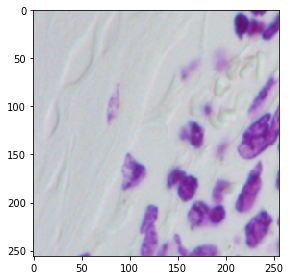

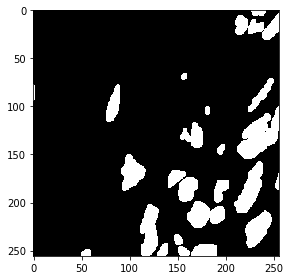

In [7]:
"""
Check results from previous steps
"""
id = 55

#train image
print(X_train[id].shape)
skimage.io.imshow(X_train[id])
plt.show()
#and its mask
skimage.io.imshow(Y_train[id][:,:,0])
plt.show()

In [10]:
"""
Definite custom metric and custom loss function
"""
def dice_coef(y_true, y_pred):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    Dice's coefficient measures how similar a set and another set are
    :param y_true:
    :param y_pred:
    :return: Dice
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)


In [11]:

"""
In this cell I created Unet model
The network architecture is a sequence of convolution + pooling layers that first reduce the spatial resolution of the image, 
and then increase it by first combining it with the image data and passing through the other layers of the convolution.
Thus, the network acts as a kind of filter.

Conv2D - The convolution layer includes for each channel its own filter, 
the convolution core of which processes the previous layer by fragments 
(summing the results of the element-by-element product for each fragment).
The weighting coefficients of the convolution kernel (small matrix) are unknown and are established in the learning process.
A feature of the convolutional layer is a relatively small number of parameters set during training.


MaxPooling2D - The pooling operation can significantly reduce the spatial volume of the image: if some signs were already detected
in the previous convolution operation, then such a detailed image is no longer needed for further processing,
and it is compressed to a less detailed one.
In addition, filtering already unnecessary parts helps not to retrain.

Dropout - The essence of the method is that in the learning process, 
a layer is selected from which a certain number of neurons are randomly thrown, 
which are turned off from further calculations. 
This technique improves learning efficiency and the quality of the result.
thus, the probability that a neuron will remain in the network is q = 1 - p.
Helps not to retrain

dice_coef - For network training, the Dice coefficient (also called the Sorensen – Dice coefficient),
which shows the measure of similarity - in this case, showing the measure of the area of correctly marked segments 
(the ratio of the intersection area) is considered to the area of the association).


"""
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#scale masks
s = Lambda(lambda x: x / 255) (inputs)
 
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
 
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
 
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
 
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
 
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
 
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
 
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [19]:
"""
Fit and train model
To achieve good results, deep networks must be trained on a very large amount of data. 
Although the UNET shows itself well on a small dataset, 
I decided that it was necessary to perform augmentation to improve the results of the model.

"""

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(f'{MODEL_NAME}', verbose=1, save_best_only=True)


size_train = len(X_train)
val_cutoff = int(size_train*0.9)
X_train2 = X_train[:val_cutoff]
Y_train2 = Y_train[:val_cutoff]
X_val = X_train[val_cutoff:]
Y_val = Y_train[val_cutoff:]
 
def data_augmentation(input, augment=False):
    #data augmentation
    if augment:
        data_gen_args = dict(shear_range=0.5, rotation_range=50, zoom_range=0.2,
                         width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
    else:
        data_gen_args = dict()
    datagen = ImageDataGenerator(**data_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    datagen.fit(input, augment=True, seed=42) 
    return datagen.flow(input, batch_size=BATCH_SIZE, shuffle=True, seed=42)
 
# combine generators into one which yields image and masks
train_generator = zip(data_augmentation(X_train2, augment=True), data_augmentation(Y_train2, augment=True))
test_generator = zip(data_augmentation(X_val), data_augmentation(Y_val))
 

results = model.fit_generator(train_generator,
                              validation_data = test_generator,
                              epochs=5,
                              steps_per_epoch =len(X_train)/(BATCH_SIZE*2),
                              validation_steps=BATCH_SIZE/2,
                              callbacks=[earlystopper, checkpointer])



Epoch 1/5
21/20 [==============================] - 116s 6s/step - loss: -0.7453 - dice_coef: 0.8299 - val_loss: -0.8150 - val_dice_coef: 0.8508

Epoch 00001: val_loss improved from inf to -0.81503, saving model to segmentation_model.h5
Epoch 2/5
21/20 [==============================] - 114s 5s/step - loss: -0.7974 - dice_coef: 0.8643 - val_loss: -0.8028 - val_dice_coef: 0.8643

Epoch 00002: val_loss did not improve from -0.81503
Epoch 3/5
21/20 [==============================] - 115s 5s/step - loss: -0.8096 - dice_coef: 0.8678 - val_loss: -0.8419 - val_dice_coef: 0.8709

Epoch 00003: val_loss improved from -0.81503 to -0.84186, saving model to segmentation_model.h5
Epoch 4/5
21/20 [==============================] - 117s 6s/step - loss: -0.8045 - dice_coef: 0.8704 - val_loss: -0.7621 - val_dice_coef: 0.8644

Epoch 00004: val_loss did not improve from -0.84186
Epoch 5/5
21/20 [==============================] - 113s 5s/step - loss: -0.7963 - dice_coef: 0.8579 - val_loss: -0.9236 - val_dic

In [20]:
"""
Load model
"""
model_loaded = Model(inputs=[inputs], outputs=[outputs])
model_loaded.load_weights(f'{MODEL_NAME}')

In [21]:
# Get test data
X_test = get_training_data(TEST_PATH, output_shape=(IMG_HEIGHT, IMG_WIDTH))

# Use model to predict test labels
Y_hat = model_loaded.predict(X_test, verbose=1)
Y_hat.shape

65/65 [==============================] - 5s 74ms/step


(65, 256, 256, 1)

(256, 256, 3)


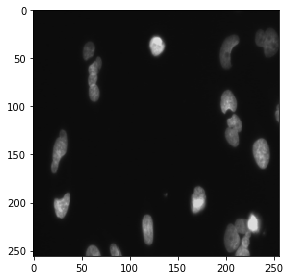

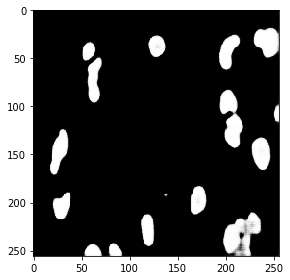

In [43]:
id = 48

#test image
print(X_test[id].shape)
skimage.io.imshow(X_test[id])
plt.show()

#predicted mask
skimage.io.imshow(Y_hat[id][:,:,0])
plt.show()